Loading data and libraries 

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from esda import Moran
from libpysal import weights
import contextily as ctx
import libpysal
import numpy as np
from esda import Moran_Local
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar
import pysal
import seaborn as sns
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors


# Load the GeoJSON data
gdf = gpd.read_file('../data/output/well_city_crash.geojson')

# Check the first few rows and the CRS
print(gdf.head())
print(gdf.crs)


   OBJECTID  advisorySpeed  areaUnitID  bicycle  bridge  bus  carStationWagon  \
0  66388986            NaN      575300      0.0     0.0  0.0              1.0   
1  66388998            NaN      572600      0.0     0.0  0.0              2.0   
2  66389034            NaN      577000      0.0     NaN  0.0              1.0   
3  66389036            NaN      576800      0.0     NaN  0.0              0.0   
4  66389128            NaN      572900      0.0     NaN  0.0              2.0   

   cliffBank crashDirectionDescription crashFinancialYear  ... tree truck  \
0        1.0                     South          2018/2019  ...  0.0   0.0   
1        0.0                     North          2017/2018  ...  0.0   0.0   
2        NaN                     South          2019/2020  ...  NaN   0.0   
3        NaN                      East          2018/2019  ...  NaN   0.0   
4        NaN                      Null          2017/2018  ...  NaN   0.0   

  unknownVehicleType  urban vanOrUtility  vehicle 

Creating geodataframe and crash counts 

In [58]:
# Load your data into a GeoDataFrame (if not already)
traffic_data = gpd.read_file('../data/output/well_city_crash.geojson')  # Example

# Ensure your GeoDataFrame has a geometry column
traffic_data = traffic_data.set_geometry('geometry')

# Assuming 'location_id' is the column that identifies the location of each crash
# If each row is a crash, you can just use the index or a unique identifier

# Group by location and count the crashes
crash_counts = (traffic_data
                .groupby('areaUnitID')  # Replace 'location_id' with your relevant column
                .size()  # Counts the number of rows per group
                .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge the crash counts back to the original GeoDataFrame
traffic_data = traffic_data.merge(crash_counts, on='areaUnitID', how='left')


Global Moran's I Map 

/opt/miniconda/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 41 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Global Moran's I: 0.9784308522237747
Expected Moran's I: -8.136696501220504e-05
Z-score: 185.7257883807918
P-value: 0.0


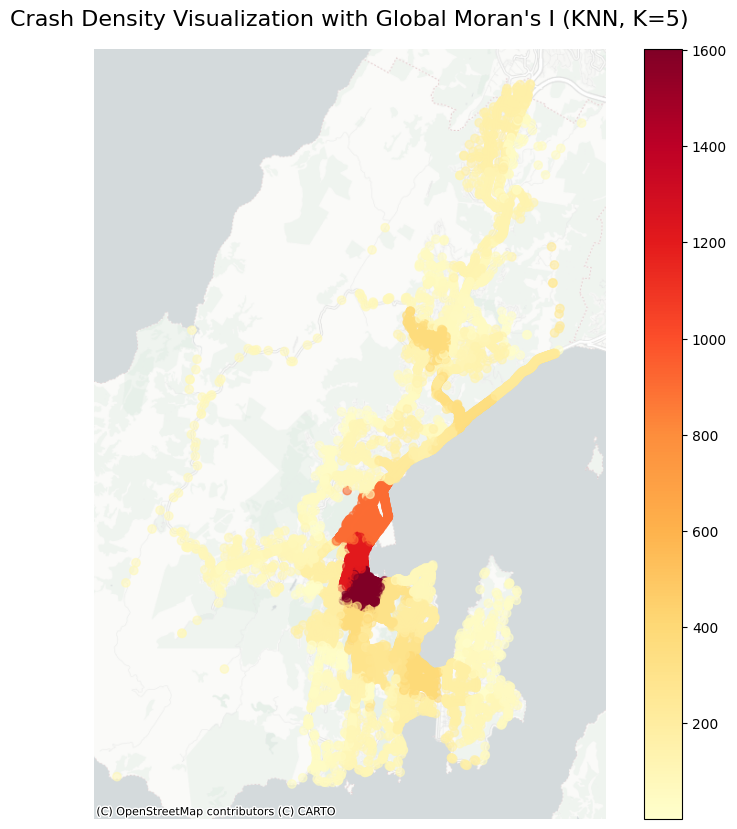

In [59]:
# Ensure the traffic data is in EPSG:3857
traffic_data = traffic_data.to_crs(epsg=3857)

# Create a KNN spatial weights matrix with K = 5
w = weights.KNN.from_dataframe(traffic_data, k=5, use_index=True)

# Calculate Global Moran's I using the Moran class
moran_global = Moran(traffic_data['crash_count'], w)

# Output Global Moran's I statistics
print(f"Global Moran's I: {moran_global.I}")
print(f"Expected Moran's I: {moran_global.EI}")
print(f"Z-score: {moran_global.z_norm}")
print(f"P-value: {moran_global.p_norm}")

# Add the global Moran's I results to the GeoDataFrame if needed
traffic_data['global_moran'] = moran_global.I

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with the original crash counts
traffic_data.plot(ax=ax, column='crash_count', cmap='YlOrRd', legend=True, alpha=0.6)

# Add the basemap
ctx.add_basemap(
    ax,
    crs=traffic_data.crs.to_string(),
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Density Visualization with Global Moran's I (KNN, K=5)", fontsize=16)

plt.show()


Local Moran's I Map For Non-Injury Crash Counts

/opt/miniconda/lib/python3.11/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


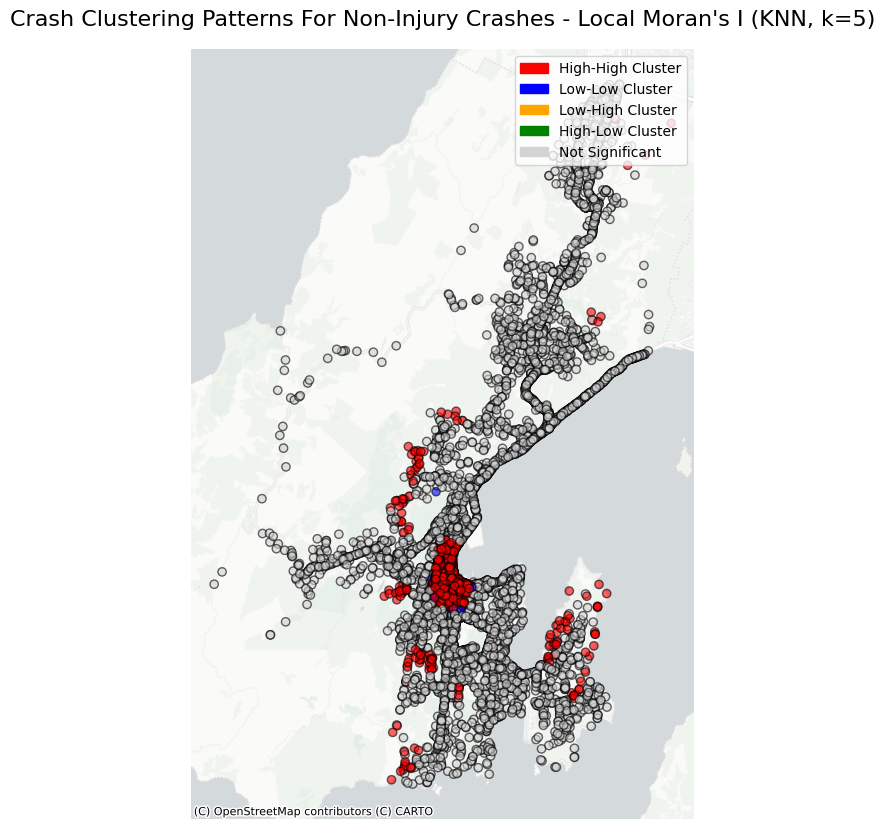

In [60]:


# Filter the data for Non-Injury Crashes
non_injury_data = traffic_data[traffic_data['crashSeverity'] == 'Non-Injury Crash']

# Group by area unit and count the Non-Injury crashes
crash_counts_non_injury = (non_injury_data
                            .groupby('areaUnitID')  # Adjust as necessary
                            .size()
                            .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_non_injury = non_injury_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_non_injury = crash_counts_geo_non_injury.merge(crash_counts_non_injury, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_non_injury = crash_counts_geo_non_injury.dropna(subset=['crash_count'])

# Ensure the crash_counts_geo_non_injury data is in EPSG:3857
crash_counts_geo_non_injury = crash_counts_geo_non_injury.to_crs(epsg=3857)

# Create a KNN spatial weights matrix with k=5
w_non_injury_knn = weights.KNN.from_dataframe(crash_counts_geo_non_injury, k=5)

# Calculate Local Moran's I using the Moran_Local class
moran_local_non_injury = Moran_Local(crash_counts_geo_non_injury['crash_count'], w_non_injury_knn)

# Add Local Moran's I results to the GeoDataFrame
crash_counts_geo_non_injury['local_moran'] = moran_local_non_injury.Is  # Local Moran's I values
crash_counts_geo_non_injury['significance'] = moran_local_non_injury.p_sim  # p-value for significance
crash_counts_geo_non_injury['z_sim'] = moran_local_non_injury.z_sim  # Standardized statistic

# Define custom thresholds based on percentiles for more balanced clusters
high_threshold_moran_non_injury = crash_counts_geo_non_injury['local_moran'].quantile(0.75)  # 75th percentile
low_threshold_moran_non_injury = crash_counts_geo_non_injury['local_moran'].quantile(0.25)   # 25th percentile

high_threshold_z_non_injury = crash_counts_geo_non_injury['z_sim'].quantile(0.75)  # 75th percentile
low_threshold_z_non_injury = crash_counts_geo_non_injury['z_sim'].quantile(0.25)   # 25th percentile

# Use a higher significance threshold to capture more clusters
significance_threshold_non_injury = 0.05

# Define conditions for each cluster type
conditions_non_injury = [
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] > high_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] > high_threshold_z_non_injury),  # high-high
    
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] < low_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] < low_threshold_z_non_injury),  # low-low
    
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] < low_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] > high_threshold_z_non_injury),  # low-high
    
    (crash_counts_geo_non_injury['significance'] < significance_threshold_non_injury) & 
    (crash_counts_geo_non_injury['local_moran'] > high_threshold_moran_non_injury) & 
    (crash_counts_geo_non_injury['z_sim'] < low_threshold_z_non_injury)   # high-low
]

# Define labels for clusters
cluster_labels_non_injury = ['high-high', 'low-low', 'low-high', 'high-low']

# Apply conditions to assign cluster types
crash_counts_geo_non_injury['cluster_type'] = np.select(conditions_non_injury, cluster_labels_non_injury, default='Not Significant')

# Define colors for each cluster type
color_mapping_non_injury = {
    'high-high': 'red',
    'low-low': 'blue',
    'low-high': 'orange',
    'high-low': 'green',
    'Not Significant': 'lightgrey'
}

# Apply color mapping
crash_counts_geo_non_injury['color'] = crash_counts_geo_non_injury['cluster_type'].map(color_mapping_non_injury)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with colors
crash_counts_geo_non_injury.plot(ax=ax, color=crash_counts_geo_non_injury['color'], alpha=0.6, edgecolor='k')

# Add the basemap
ctx.add_basemap(
    ax,  # Pass the axis to the basemap
    crs=crash_counts_geo_non_injury.crs.to_string(),  # Use the crash_counts_geo_non_injury data's CRS
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Clustering Patterns For Non-Injury Crashes - Local Moran's I (KNN, k=5)", fontsize=16)

# Create a custom legend
import matplotlib.patches as mpatches

legend_elements_non_injury = [
    mpatches.Patch(color='red', label='High-High Cluster'),
    mpatches.Patch(color='blue', label='Low-Low Cluster'),
    mpatches.Patch(color='orange', label='Low-High Cluster'),
    mpatches.Patch(color='green', label='High-Low Cluster'),
    mpatches.Patch(color='lightgrey', label='Not Significant')
]

ax.legend(handles=legend_elements_non_injury, loc='upper right')

# Save the figure as a PDF
#plt.savefig("non_injury_crash_clustering.pdf", bbox_inches='tight')

# Show the plot
plt.show()


Local Moran's I For Minor Crash Counts

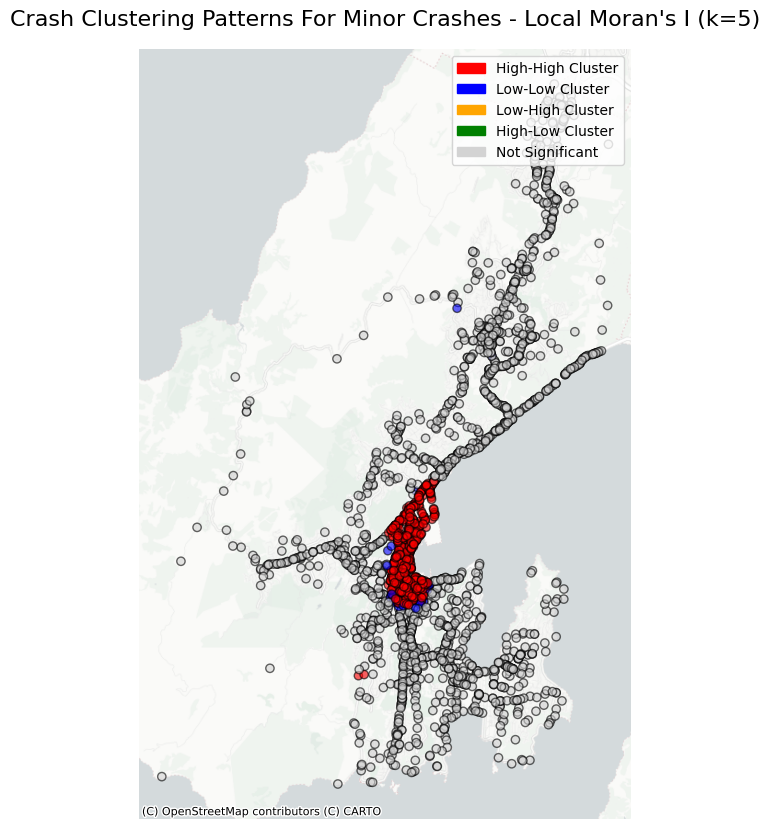

In [61]:

# Filter the data for Minor Crashes
minor_data = traffic_data[traffic_data['crashSeverity'] == 'Minor Crash']

# Group by area unit and count the minor crashes
crash_counts_minor = (minor_data
                      .groupby('areaUnitID')  # Adjust as necessary
                      .size()
                      .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_minor = minor_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_minor = crash_counts_geo_minor.merge(crash_counts_minor, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_minor = crash_counts_geo_minor.dropna(subset=['crash_count'])

# Ensure the crash_counts_geo_minor data is in EPSG:3857
crash_counts_geo_minor = crash_counts_geo_minor.to_crs(epsg=3857)

# Create a spatial weights matrix using k-nearest neighbors (INN) with k=5
w_minor = weights.KNN.from_dataframe(crash_counts_geo_minor, k=10)

# Calculate Local Moran's I using the Moran_Local class
moran_local_minor = Moran_Local(crash_counts_geo_minor['crash_count'], w_minor)

# Add Local Moran's I results to the GeoDataFrame
crash_counts_geo_minor['local_moran'] = moran_local_minor.Is  # Local Moran's I values
crash_counts_geo_minor['significance'] = moran_local_minor.p_sim  # p-value for significance
crash_counts_geo_minor['z_sim'] = moran_local_minor.z_sim  # Standardized statistic

# Define custom thresholds based on percentiles for more balanced clusters
high_threshold_moran_minor = crash_counts_geo_minor['local_moran'].quantile(0.75)  # 75th percentile
low_threshold_moran_minor = crash_counts_geo_minor['local_moran'].quantile(0.25)   # 25th percentile

high_threshold_z_minor = crash_counts_geo_minor['z_sim'].quantile(0.75)  # 75th percentile
low_threshold_z_minor = crash_counts_geo_minor['z_sim'].quantile(0.25)   # 25th percentile

# Use a higher significance threshold to capture more clusters
significance_threshold_minor = 0.05

# Define conditions for each cluster type
conditions_minor = [
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] > high_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] > high_threshold_z_minor),  # high-high
    
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] < low_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] < low_threshold_z_minor),  # low-low
    
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] < low_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] > high_threshold_z_minor),  # low-high
    
    (crash_counts_geo_minor['significance'] < significance_threshold_minor) & 
    (crash_counts_geo_minor['local_moran'] > high_threshold_moran_minor) & 
    (crash_counts_geo_minor['z_sim'] < low_threshold_z_minor)   # high-low
]

# Define labels for clusters
cluster_labels_minor = ['high-high', 'low-low', 'low-high', 'high-low']

# Apply conditions to assign cluster types
crash_counts_geo_minor['cluster_type'] = np.select(conditions_minor, cluster_labels_minor, default='Not Significant')

# Define colors for each cluster type
color_mapping_minor = {
    'high-high': 'red',
    'low-low': 'blue',
    'low-high': 'orange',
    'high-low': 'green',
    'Not Significant': 'lightgrey'
}

# Apply color mapping
crash_counts_geo_minor['color'] = crash_counts_geo_minor['cluster_type'].map(color_mapping_minor)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with colors
crash_counts_geo_minor.plot(ax=ax, color=crash_counts_geo_minor['color'], alpha=0.6, edgecolor='k')  # Added edgecolor for visibility

# Add the basemap
ctx.add_basemap(
    ax,  # Pass the axis to the basemap
    crs=crash_counts_geo_minor.crs.to_string(),  # Use the crash_counts_geo_minor data's CRS
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Clustering Patterns For Minor Crashes - Local Moran's I (k=5)", fontsize=16)

# Create a custom legend
import matplotlib.patches as mpatches

legend_elements_minor = [
    mpatches.Patch(color='red', label='High-High Cluster'),
    mpatches.Patch(color='blue', label='Low-Low Cluster'),
    mpatches.Patch(color='orange', label='Low-High Cluster'),
    mpatches.Patch(color='green', label='High-Low Cluster'),
    mpatches.Patch(color='lightgrey', label='Not Significant')
]

ax.legend(handles=legend_elements_minor, loc='upper right')

# Save the figure as a PDF
#plt.savefig("minor_crash_clustering.pdf", bbox_inches='tight')

# Show the plot
plt.show()


Local Moran's I For Fatal and Serious Crashes

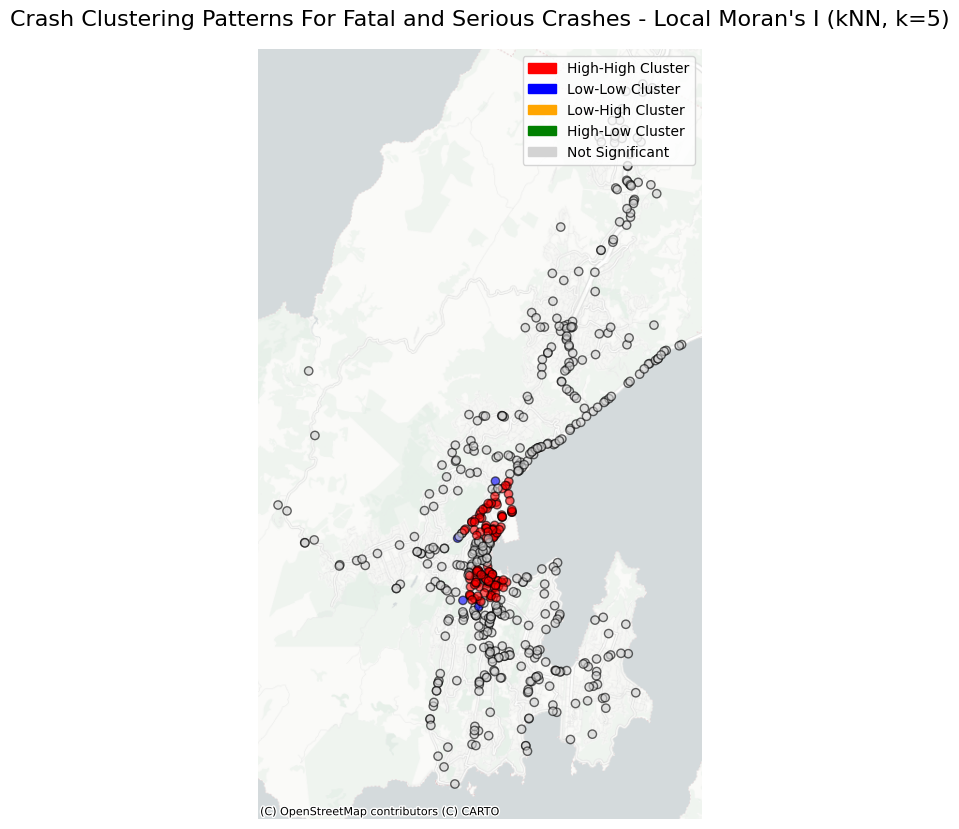

In [62]:

# Filter the data for Fatal and Serious Crashes
fatal_serious_data = traffic_data[(traffic_data['crashSeverity'] == 'Fatal Crash') | 
                                   (traffic_data['crashSeverity'] == 'Serious Crash')]

# Group by area unit and count the Fatal and Serious crashes
crash_counts_fatal_serious = (fatal_serious_data
                               .groupby('areaUnitID')  # Adjust as necessary
                               .size()
                               .reset_index(name='crash_count'))  # Create a DataFrame with counts

# Merge crash counts back to the original GeoDataFrame to retain geometry
crash_counts_geo_fatal_serious = fatal_serious_data[['areaUnitID', 'geometry']].drop_duplicates()
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.merge(crash_counts_fatal_serious, on='areaUnitID', how='left')

# Clean your data: drop rows with NaN values in the crash count column
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.dropna(subset=['crash_count'])

# Ensure the crash_counts_geo_fatal_serious data is in EPSG:3857
crash_counts_geo_fatal_serious = crash_counts_geo_fatal_serious.to_crs(epsg=3857)

# Create a kNN spatial weights matrix with k=5
w_fatal_serious_knn = weights.KNN.from_dataframe(crash_counts_geo_fatal_serious, k=5)

# Calculate Local Moran's I using the Moran_Local class
moran_local_fatal_serious = Moran_Local(crash_counts_geo_fatal_serious['crash_count'], w_fatal_serious_knn)

# Add Local Moran's I results to the GeoDataFrame
crash_counts_geo_fatal_serious['local_moran'] = moran_local_fatal_serious.Is  # Local Moran's I values
crash_counts_geo_fatal_serious['significance'] = moran_local_fatal_serious.p_sim  # p-value for significance
crash_counts_geo_fatal_serious['z_sim'] = moran_local_fatal_serious.z_sim  # Standardized statistic

# Define custom thresholds based on percentiles for more balanced clusters
high_threshold_moran_fatal_serious = crash_counts_geo_fatal_serious['local_moran'].quantile(0.75)  # 75th percentile
low_threshold_moran_fatal_serious = crash_counts_geo_fatal_serious['local_moran'].quantile(0.25)   # 25th percentile

high_threshold_z_fatal_serious = crash_counts_geo_fatal_serious['z_sim'].quantile(0.75)  # 75th percentile
low_threshold_z_fatal_serious = crash_counts_geo_fatal_serious['z_sim'].quantile(0.25)   # 25th percentile

# Use a higher significance threshold to capture more clusters
significance_threshold_fatal_serious = 0.05

# Define conditions for each cluster type
conditions_fatal_serious = [
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] > high_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] > high_threshold_z_fatal_serious),  # high-high
    
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] < low_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] < low_threshold_z_fatal_serious),  # low-low
    
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] < low_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] > high_threshold_z_fatal_serious),  # low-high
    
    (crash_counts_geo_fatal_serious['significance'] < significance_threshold_fatal_serious) & 
    (crash_counts_geo_fatal_serious['local_moran'] > high_threshold_moran_fatal_serious) & 
    (crash_counts_geo_fatal_serious['z_sim'] < low_threshold_z_fatal_serious)   # high-low
]

# Define labels for clusters
cluster_labels_fatal_serious = ['high-high', 'low-low', 'low-high', 'high-low']

# Apply conditions to assign cluster types
crash_counts_geo_fatal_serious['cluster_type'] = np.select(conditions_fatal_serious, cluster_labels_fatal_serious, default='Not Significant')

# Define colors for each cluster type
color_mapping_fatal_serious = {
    'high-high': 'red',
    'low-low': 'blue',
    'low-high': 'orange',
    'high-low': 'green',
    'Not Significant': 'lightgrey'
}

# Apply color mapping
crash_counts_geo_fatal_serious['color'] = crash_counts_geo_fatal_serious['cluster_type'].map(color_mapping_fatal_serious)

# Plot the data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the GeoDataFrame with colors
crash_counts_geo_fatal_serious.plot(ax=ax, color=crash_counts_geo_fatal_serious['color'], alpha=0.6, edgecolor='k')  # Added edgecolor for visibility

# Add the basemap
ctx.add_basemap(
    ax,  # Pass the axis to the basemap
    crs=crash_counts_geo_fatal_serious.crs.to_string(),  # Use the crash_counts_geo_fatal_serious data's CRS
    source=ctx.providers.CartoDB.PositronNoLabels
)

# Remove axes for better visualization
ax.set_axis_off()

# Add a title
plt.title("Crash Clustering Patterns For Fatal and Serious Crashes - Local Moran's I (kNN, k=5)", fontsize=16)

# Create a custom legend
import matplotlib.patches as mpatches

legend_elements_fatal_serious = [
    mpatches.Patch(color='red', label='High-High Cluster'),
    mpatches.Patch(color='blue', label='Low-Low Cluster'),
    mpatches.Patch(color='orange', label='Low-High Cluster'),
    mpatches.Patch(color='green', label='High-Low Cluster'),
    mpatches.Patch(color='lightgrey', label='Not Significant')
]

ax.legend(handles=legend_elements_fatal_serious, loc='upper right')

# Save the figure as a PDF
#plt.savefig("serious_crash_clustering.pdf", bbox_inches='tight')

# Show the plot
plt.show()


Combining All three Maps into one Frame (With Not Significant Points)

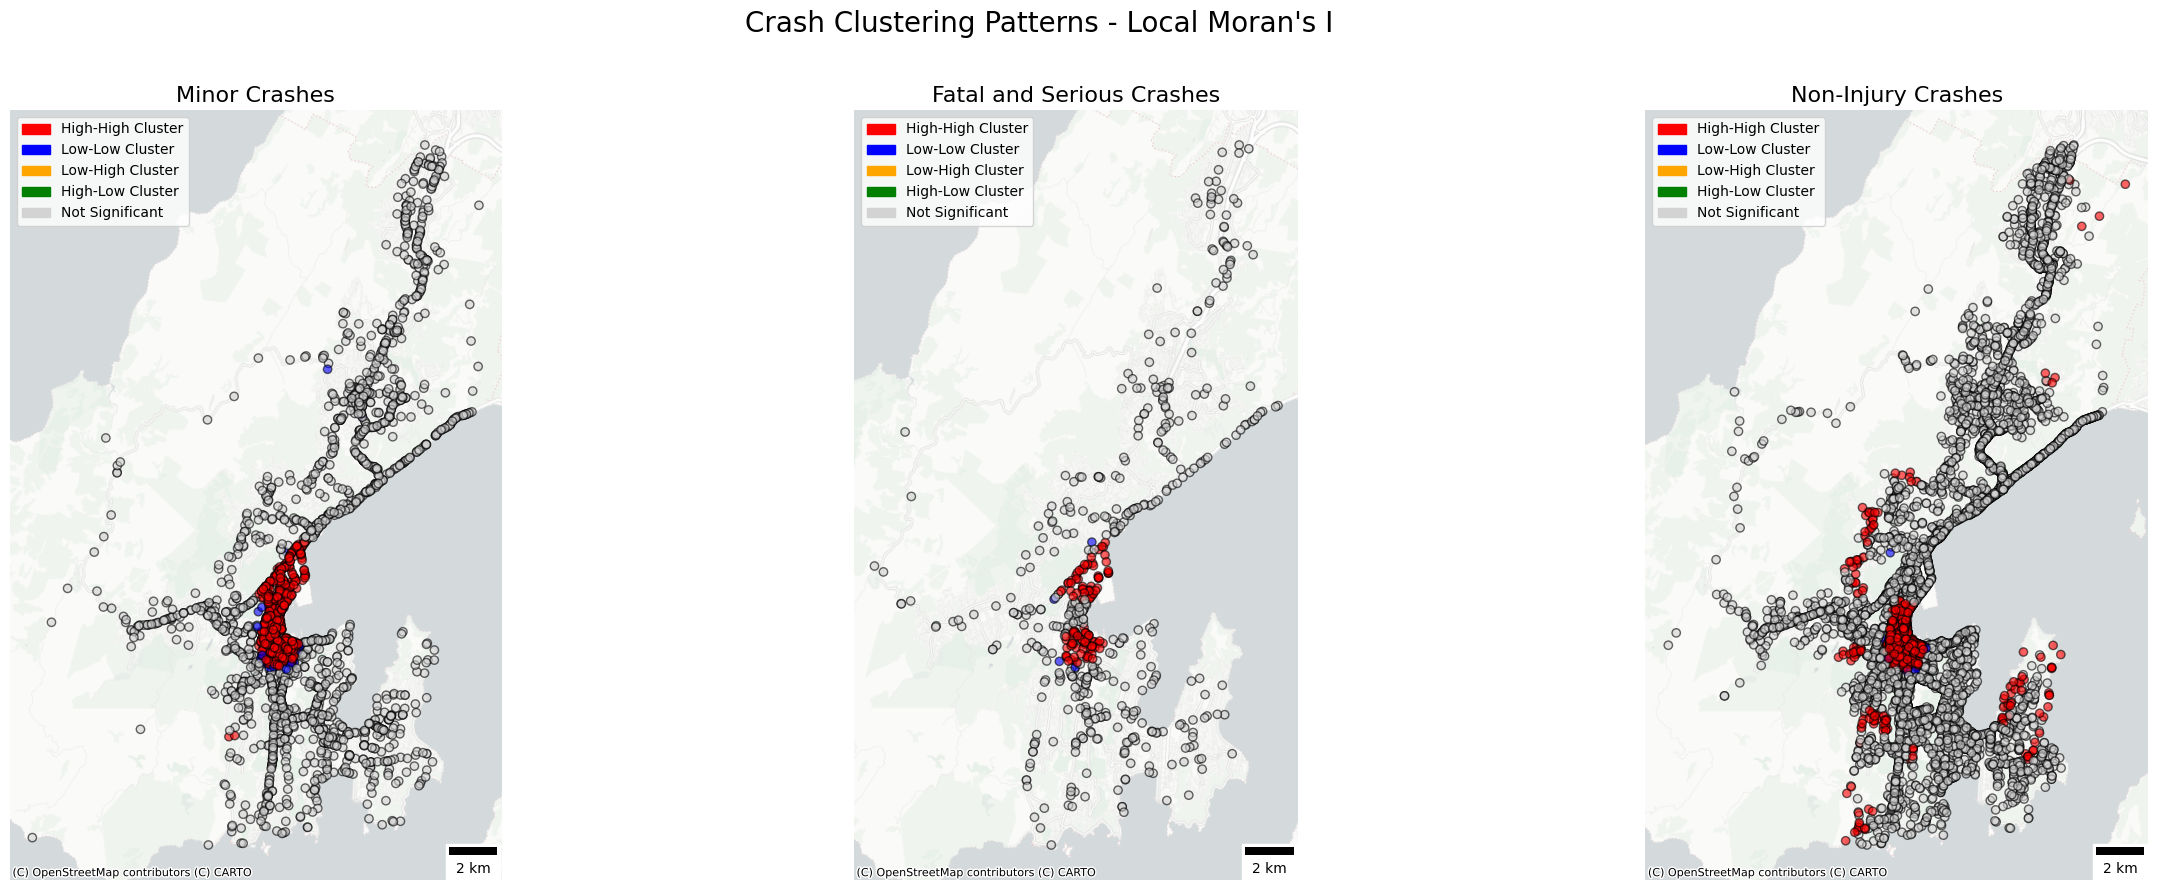

In [63]:

# Define the figure and axis layout for three subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Titles for each map
titles = ["Minor Crashes", "Fatal and Serious Crashes", "Non-Injury Crashes"]

# Data sets for each map (including 'Not Significant')
datasets = [
    crash_counts_geo_minor,
    crash_counts_geo_fatal_serious,
    crash_counts_geo_non_injury
]

# Loop through each dataset and plot on its respective subplot
for i, ax in enumerate(axs):
    dataset = datasets[i]
    
    # Plot the GeoDataFrame with colors
    dataset.plot(ax=ax, color=dataset['color'], alpha=0.6, edgecolor='k')
    
    # Add the basemap
    ctx.add_basemap(
        ax,
        crs=dataset.crs.to_string(),
        source=ctx.providers.CartoDB.PositronNoLabels
    )
    
    # Remove axes for better visualization
    ax.set_axis_off()
    
    # Set title
    ax.set_title(titles[i], fontsize=16)

    # Create custom legends for all three maps
    legend_elements = [
        mpatches.Patch(color='red', label='High-High Cluster'),
        mpatches.Patch(color='blue', label='Low-Low Cluster'),
        mpatches.Patch(color='orange', label='Low-High Cluster'),
        mpatches.Patch(color='green', label='High-Low Cluster'),
        mpatches.Patch(color='lightgrey', label='Not Significant')  # Include 'Not Significant' in legend
    ]

    # Add a legend to each plot
    ax.legend(handles=legend_elements, loc='upper left')
    
    # Add a scale bar to each map
    ax.add_artist(ScaleBar(1, location='lower right'))  # Adjust the scale bar length as needed

# Set a common title for the entire layout
fig.suptitle("Crash Clustering Patterns - Local Moran's I", fontsize=20)

# Save the combined figure as a PDF
#plt.savefig("combined_crash_clustering_with_legends_and_scale_bars.pdf", bbox_inches='tight')

# Show the plot
plt.show()


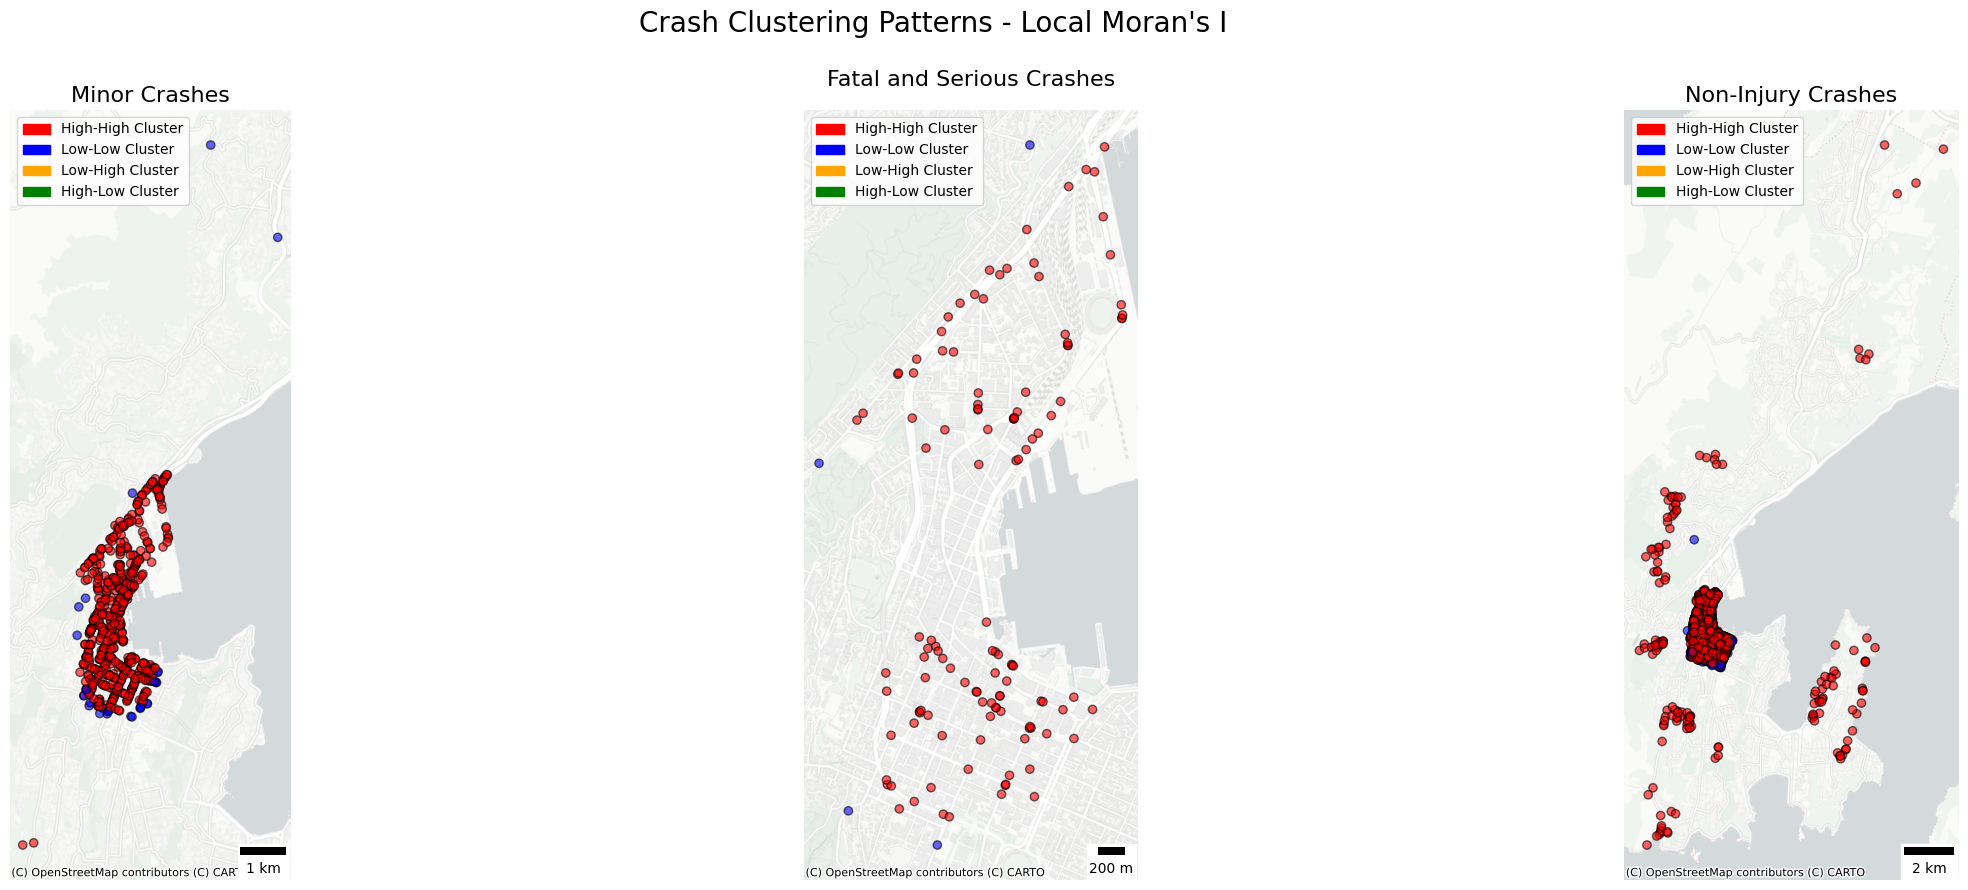

In [64]:
# Define the figure and axis layout for three subplots
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

# Titles for each map
titles = ["Minor Crashes", "Fatal and Serious Crashes", "Non-Injury Crashes"]

# Data sets for each map (including 'Not Significant')
datasets = [
    crash_counts_geo_minor,
    crash_counts_geo_fatal_serious,
    crash_counts_geo_non_injury
]

# Loop through each dataset and plot on its respective subplot
for i, ax in enumerate(axs):
    dataset = datasets[i]
    
    # Filter out 'Not Significant' points (assuming 'lightgrey' represents not significant)
    dataset_filtered = dataset[dataset['color'] != 'lightgrey']
    
    # Plot the GeoDataFrame with filtered data and colors
    dataset_filtered.plot(ax=ax, color=dataset_filtered['color'], alpha=0.6, edgecolor='k')
    
    # Add the basemap
    ctx.add_basemap(
        ax,
        crs=dataset.crs.to_string(),
        source=ctx.providers.CartoDB.PositronNoLabels
    )
    
    # Remove axes for better visualization
    ax.set_axis_off()
    
    # Set title
    ax.set_title(titles[i], fontsize=16)

    # Create custom legends for all three maps (excluding 'Not Significant')
    legend_elements = [
        mpatches.Patch(color='red', label='High-High Cluster'),
        mpatches.Patch(color='blue', label='Low-Low Cluster'),
        mpatches.Patch(color='orange', label='Low-High Cluster'),
        mpatches.Patch(color='green', label='High-Low Cluster')
    ]

    # Add a legend to each plot
    ax.legend(handles=legend_elements, loc='upper left')
    
    # Add a scale bar to each map
    ax.add_artist(ScaleBar(1, location='lower right'))  # Adjust the scale bar length as needed

# Set a common title for the entire layout
fig.suptitle("Crash Clustering Patterns - Local Moran's I", fontsize=20)

# Save the combined figure as a PDF
#plt.savefig("combined_crash_clustering_with_legends_and_scale_bars.pdf", bbox_inches='tight')

# Show the plot
plt.show()


Wellington Kernel Density Estimation Maps

In [65]:
traffic_data_kde = gpd.read_file('well_city_crash.geojson')

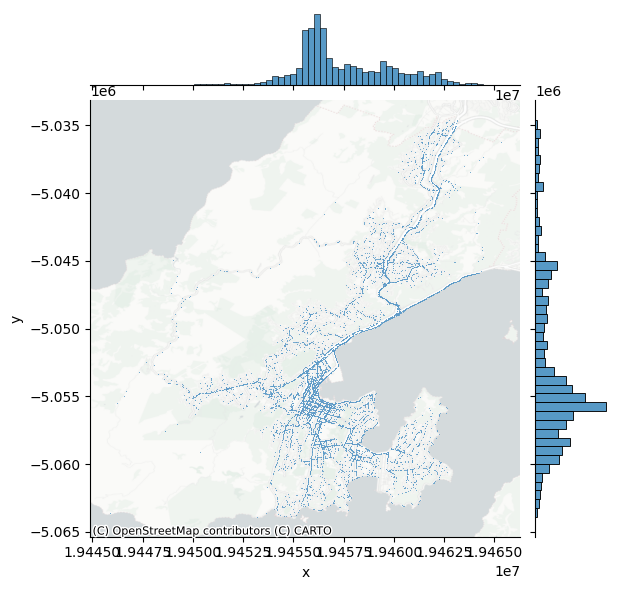

In [66]:

# Ensure the traffic data is in EPSG:3857
traffic_data_kde = traffic_data_kde.to_crs(epsg=3857)

# Extract the x and y coordinates from the geometry column
traffic_data_kde['x'] = traffic_data_kde['geometry'].apply(lambda geom: geom.x)
traffic_data_kde['y'] = traffic_data_kde['geometry'].apply(lambda geom: geom.y)

# Generate the scatter plot
joint_axes = sns.jointplot(x="x", y="y", data=traffic_data_kde, s=0.5)

# Add the basemap
ctx.add_basemap(
    joint_axes.ax_joint,
    crs=traffic_data_kde.crs.to_string(),  # Use the traffic data's CRS
    source=ctx.providers.CartoDB.PositronNoLabels
)

plt.show()


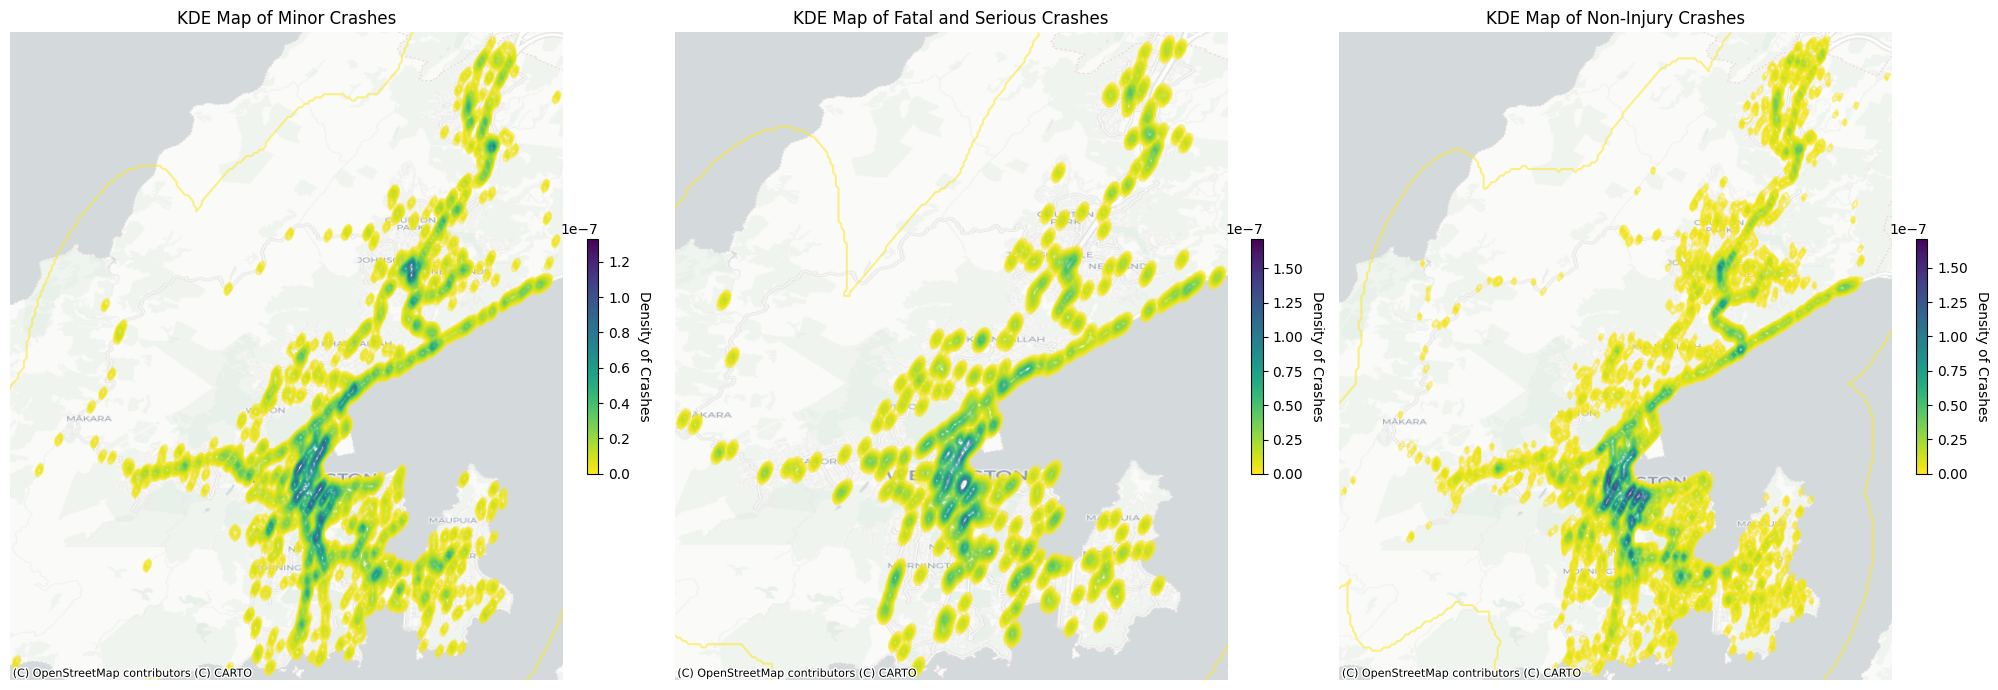

In [67]:


# Function to create KDE map for a given GeoDataFrame
def plot_kde_map(crash_data, title, ax):
    # Ensure the data is a GeoDataFrame
    crash_data = gpd.GeoDataFrame(crash_data, geometry='geometry')

    # Reproject to EPSG:3857 (Web Mercator) for compatibility with the basemap
    crash_data = crash_data.to_crs(epsg=3857)

    # Create a new DataFrame with the x and y coordinates
    coords_df = pd.DataFrame({
        'x': crash_data.geometry.x,
        'y': crash_data.geometry.y
    })

    # Generate KDE with adjusted bandwidth and store the output
    kde = sns.kdeplot(
        data=coords_df,
        x='x',
        y='y',
        fill=False,  
        thresh=0,
        levels=50,
        alpha=0.55,
        cmap="viridis_r",
        ax=ax,
        bw_adjust=0.1
    )

    # Add basemap
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.Positron,
        crs=crash_data.crs.to_string()  # Use crash_data CRS (EPSG:3857)
    )

    # Set title
    ax.set_title(title)

    # Remove axes
    ax.set_axis_off()

    # Create colorbar
    norm = mcolors.Normalize(vmin=kde.collections[0].get_array().min(), 
                             vmax=kde.collections[0].get_array().max())
    sm = plt.cm.ScalarMappable(cmap="viridis_r", norm=norm)
    sm.set_array([])  # Only needed for older Matplotlib versions
    cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.04)
    cbar.set_label('Density of Crashes', rotation=270, labelpad=15)
    cbar.ax.tick_params(labelsize=10)

# Set up the figure and axes for three KDE maps
fig, axs = plt.subplots(1, 3, figsize=(20, 7))

# Plot KDE maps for each crash type
plot_kde_map(crash_counts_geo_minor, "KDE Map of Minor Crashes", axs[0])
plot_kde_map(crash_counts_geo_fatal_serious, "KDE Map of Fatal and Serious Crashes", axs[1])
plot_kde_map(crash_counts_geo_non_injury, "KDE Map of Non-Injury Crashes", axs[2])

# Adjust layout
plt.tight_layout()

# Save the figure as a PDF
# plt.savefig("kde_crash_clustering.pdf", bbox_inches='tight')

plt.show()
